In [2]:
#  Copyright 2022 Institute of Advanced Research in Artificial Intelligence (IARAI) GmbH.
#  IARAI licenses this file to You under the Apache License, Version 2.0
#  (the "License"); you may not use this file except in compliance with
#  the License. You may obtain a copy of the License at
#  http://www.apache.org/licenses/LICENSE-2.0
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

In [3]:
import os
import sys
# Alternatevly, in order to make the module imports work properly set PYTHONPATH=$PWD before launching the notebook server from the repo root folder.
sys.path.insert(0, os.path.abspath("../"))  # noqa:E402

![t4c20logo](../t4c20logo.png)

In [4]:
import statistics
from collections import defaultdict

import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric
import tqdm
from IPython.core.display import HTML
from IPython.display import display
from torch import nn
from torch_geometric.nn import MessagePassing
from pathlib import Path
import numpy as np

import t4c22
from t4c22.metric.masked_crossentropy import get_weights_from_class_fractions
from t4c22.misc.t4c22_logging import t4c_apply_basic_logging_config
from t4c22.t4c22_config import class_fractions
from t4c22.t4c22_config import load_basedir
from t4c22.dataloading.t4c22_dataset_geometric import T4c22GeometricDataset
from t4c22.plotting.plot_congestion_classification import plot_segment_classifications_simple
from t4c22.misc.notebook_helpers import restartkernel  # noqa:F401

%matplotlib inline
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60
display(HTML("<style>.container { width:80% !important; }</style>"))

The time module is not an IPython extension.


Autosaving every 60 seconds


In [58]:
t4c_apply_basic_logging_config(loglevel="DEBUG")
# load BASEDIR from file, change to your data root
BASEDIR = load_basedir(fn="t4c22_config.json", pkg=t4c22)
#city = "london"
#city = "melbourne"
city = "madrid"
dataset = T4c22GeometricDataset(root=BASEDIR, city=city, split="train", cachedir=Path("tmp/processed"), add_nearest_ctr_edge=True)
# train_dataset = T4c22GeometricDataset(root=BASEDIR, city=city, split="train", cachedir=Path("/tmp/processed5"), limit=1000)
dataset.get(1), len(dataset)

(Data(x=[63397, 6], edge_index=[2, 179080], y=[179080]), 6976)

In [59]:
# Writing data to cache
for data in tqdm.notebook.tqdm(torch_geometric.loader.dataloader.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=16)):
    continue

  0%|          | 0/436 [00:00<?, ?it/s]

## Torch Geometric Dataset

## Testing

In [29]:
city_class_fractions = class_fractions[city]
city_class_fractions

{'green': 0.7018930324884697,
 'yellow': 0.2223245729555099,
 'red': 0.0757823945560204}

In [30]:
city_class_weights = get_weights_from_class_fractions([city_class_fractions[c] for c in ["green", "yellow", "red"]])
# city_class_weights.append(0.1) # weight for no data
city_class_weights = torch.tensor(city_class_weights).float()
city_class_weights

tensor([0.4749, 1.4993, 4.3986])

## Looking into London samples

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from GNN_model import CongestioNN
from GNN_model import LinkPredictor
import json

@torch.no_grad()
def create_prediction(dataset, model, predictor, day):
    model.to(device)
    predictor.to(device)
    city_class_weights.to(device)
    loss_f = torch.nn.CrossEntropyLoss(weight=city_class_weights, ignore_index=-1, reduction="mean")
    loss_f.to(device)
    dfs = []

    for idx, data in tqdm.notebook.tqdm(enumerate(dataset), total=len(dataset)):

        data.x = data.x.nan_to_num(-1)
        data.y = data.y.nan_to_num(3)
        data = data.to(device)
        h = model(data)

        x_i = torch.index_select(h, 0, data.edge_index[0])
        x_j = torch.index_select(h, 0, data.edge_index[1])

        # logits
        y_hat = predictor(x_i, x_j)
        df = pd.DataFrame(torch.nn.functional.softmax(y_hat, dim=1).cpu().numpy(), columns=["0", "1", "2"])
        df_data = dataset.torch_road_graph_mapping._torch_to_df_cc(data=y_hat, day=day, t=idx)
        df["u"] = df_data["u"].copy(deep=True)
        df["v"] = df_data["v"].copy(deep=True)
        df["day"] = df_data["day"].copy(deep=True)
        df["t"] = df_data["t"].copy(deep=True)
        # print(data.y.cpu().numpy())
        df["y"] = data.y.cpu().numpy()
        df["y_hat"] = df[["0", "1", "2"]].idxmax(axis=1).astype("int64")
        dfs.append(df)

    return dfs

epochs = 1
city = "madrid"
# Monday
day = "2021-07-01"

device = 1
device = f"cuda:{device}" if torch.cuda.is_available() else "cpu"
device = torch.device(device)


with open("model_parameters.json", "r") as f:
    model_parameters = json.load(f)

t4c_apply_basic_logging_config(loglevel="INFO")

# load BASEDIR from file, change to your data root
BASEDIR = load_basedir(fn="t4c22_config.json", pkg=t4c22)
dataset = T4c22GeometricDataset(root=BASEDIR, city=city, split="train", cachedir=Path("tmp/processed"), add_nearest_ctr_edge=True, day_t_filter=lambda _day, t: _day == day)

model = CongestioNN(**model_parameters["GNN"])
model.load_state_dict(torch.load(f"{city}_model_{epochs:03d}.pt", map_location=device))

predictor = LinkPredictor(**model_parameters["Predictor"])
predictor.load_state_dict(torch.load(f"{city}_predictor_{epochs:03d}.pt", map_location=device))

df = create_prediction(dataset, model, predictor, day)
plot_df = pd.concat(df).reset_index(drop=True)
plot_df

  0%|          | 0/92 [00:00<?, ?it/s]

,0,1,2,u,v,day,t,y,y_hat
0,0.462452,0.322579,0.214969,315364833,1498420147,2021-07-01,0,0.0,0
1,0.336315,0.336371,0.327314,367772717,1224507518,2021-07-01,0,3.0,1
2,0.533647,0.240413,0.225939,570759737,307720103,2021-07-01,0,0.0,0
3,0.427621,0.309595,0.262783,301793761,538387218,2021-07-01,0,3.0,0
4,0.560389,0.222392,0.217220,3120941794,3120957144,2021-07-01,0,3.0,0
...,...,...,...,...,...,...,...,...,...
16475355,0.364060,0.331619,0.304321,9699225798,27517507,2021-07-01,91,3.0,0
16475356,0.424426,0.264807,0.310767,308581619,308586387,2021-07-01,91,3.0,0
16475357,0.446631,0.289121,0.264248,364718801,310087255,2021-07-01,91,0.0,0
16475358,0.491409,0.307077,0.201515,359986650,3110253479,2021-07-01,91,3.0,0


<AxesSubplot:xlabel='2', ylabel='Count'>

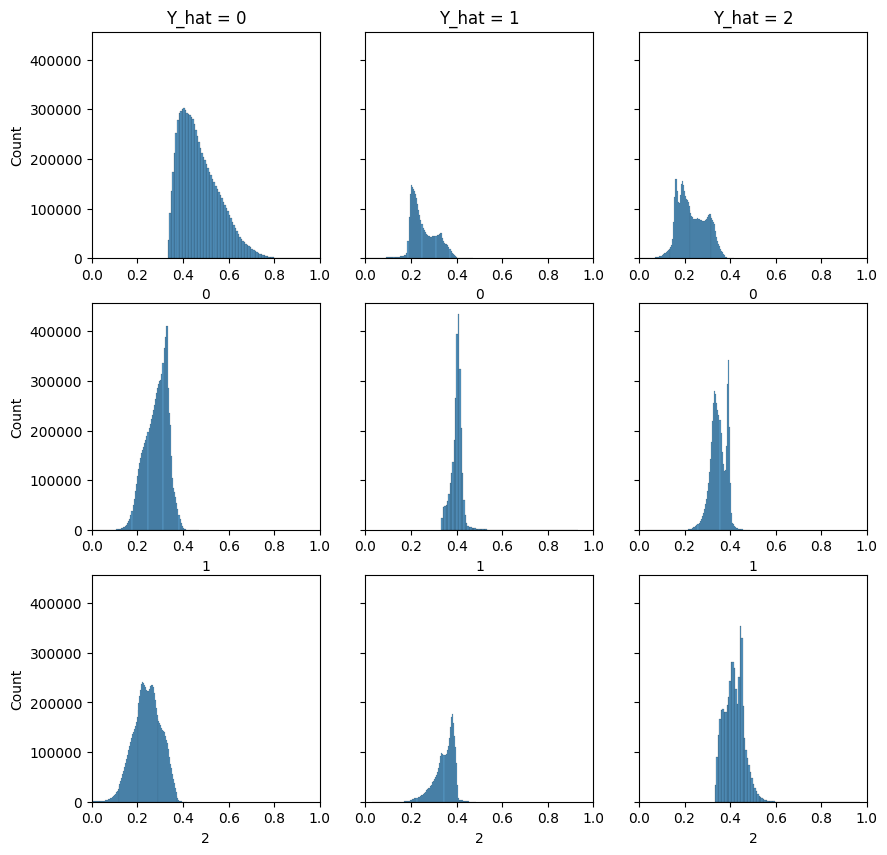

In [62]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), sharey=True)

bins = 100
for i in range(3):
    for j in range(3):
        axs[i,j].set_xlim([0.0, 1.0])

cols = ['Y_hat = {}'.format(col) for col in range(3)]
for ax, col in zip(axs[0], cols):
    ax.set_title(col)

sns.histplot(data=plot_df[plot_df["y_hat"] == 0], x="0", bins=bins, ax=axs[0,0])
sns.histplot(data=plot_df[plot_df["y_hat"] == 0], x="1", bins=bins, ax=axs[1,0])
sns.histplot(data=plot_df[plot_df["y_hat"] == 0], x="2", bins=bins, ax=axs[2,0])

sns.histplot(data=plot_df[plot_df["y_hat"] == 1], x="0", bins=bins, ax=axs[0,1])
sns.histplot(data=plot_df[plot_df["y_hat"] == 1], x="1", bins=bins, ax=axs[1,1])
sns.histplot(data=plot_df[plot_df["y_hat"] == 1], x="2", bins=bins, ax=axs[2,1])

sns.histplot(data=plot_df[plot_df["y_hat"] == 2], x="0", bins=bins, ax=axs[0,2])
sns.histplot(data=plot_df[plot_df["y_hat"] == 2], x="1", bins=bins, ax=axs[1,2])
sns.histplot(data=plot_df[plot_df["y_hat"] == 2], x="2", bins=bins, ax=axs[2,2])
#sns.histplot(data=plot_df, x="3", bins=bins, ax=axs[3])

In [ ]:
from sklearn.metrics import confusion_matrix

confm = confusion_matrix(plot_df["y"], plot_df["y_hat"], normalize="true")
ax = sns.heatmap(confm, annot=True)
ax.set(xlabel='Prediction', ylabel='True Label')

In [12]:
def plot(u,v, df):
    df_ = df[(df["u"] == u) & (df["v"] == v)].copy(deep=True)
    df_["loss"] = 1.
    fig, ax = plot_segment_classifications_simple(
        df_["y_hat"].values,
        df_["y"].values,
        losses=df_["loss"].values,
        proba_green=df_["0"],
        proba_yellow=df_["1"],
        proba_red=df_["2"],
    )

[2022-08-18 20:15:41,280][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:41,308][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:41,334][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:41,370][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:41,402][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:41,444][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:41,500][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:41,515][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in

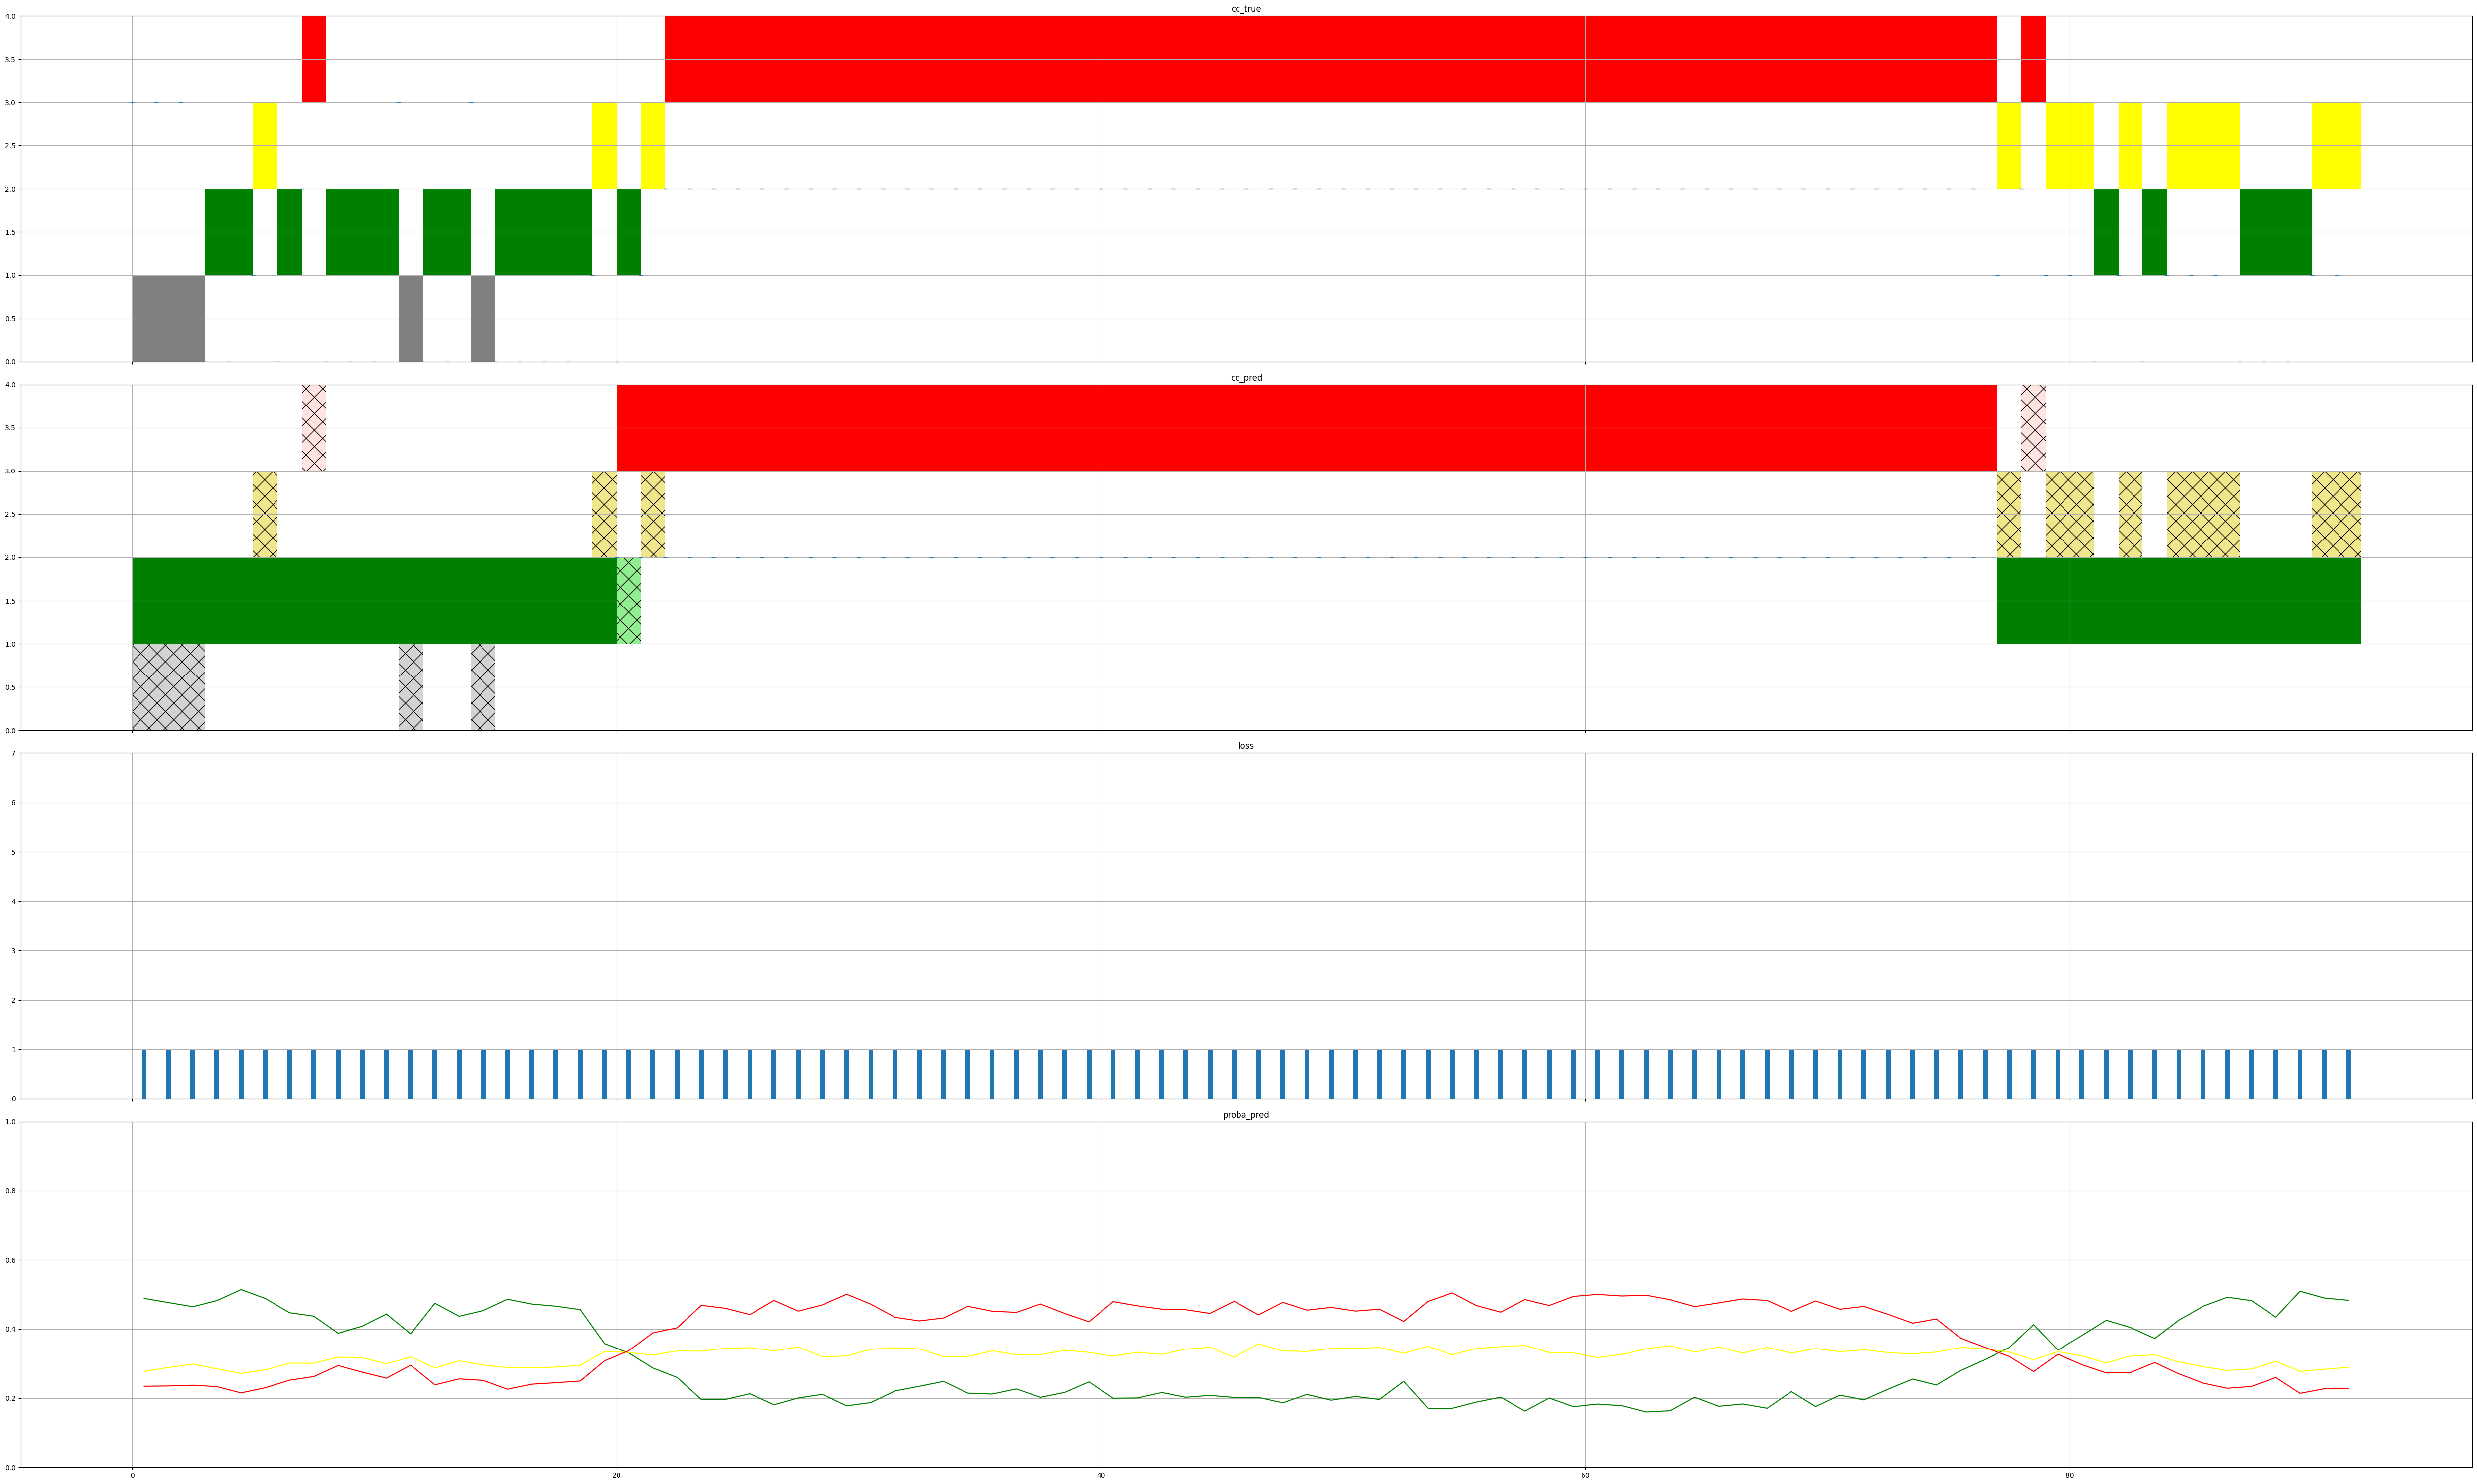

In [21]:
# Marleybone flyover, eastbound
u = 1178910690
v = 197630

plot(u, v, plot_df)

[2022-08-18 20:15:51,788][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:51,814][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:51,844][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:51,880][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:51,915][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:51,977][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:52,034][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:15:52,049][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in

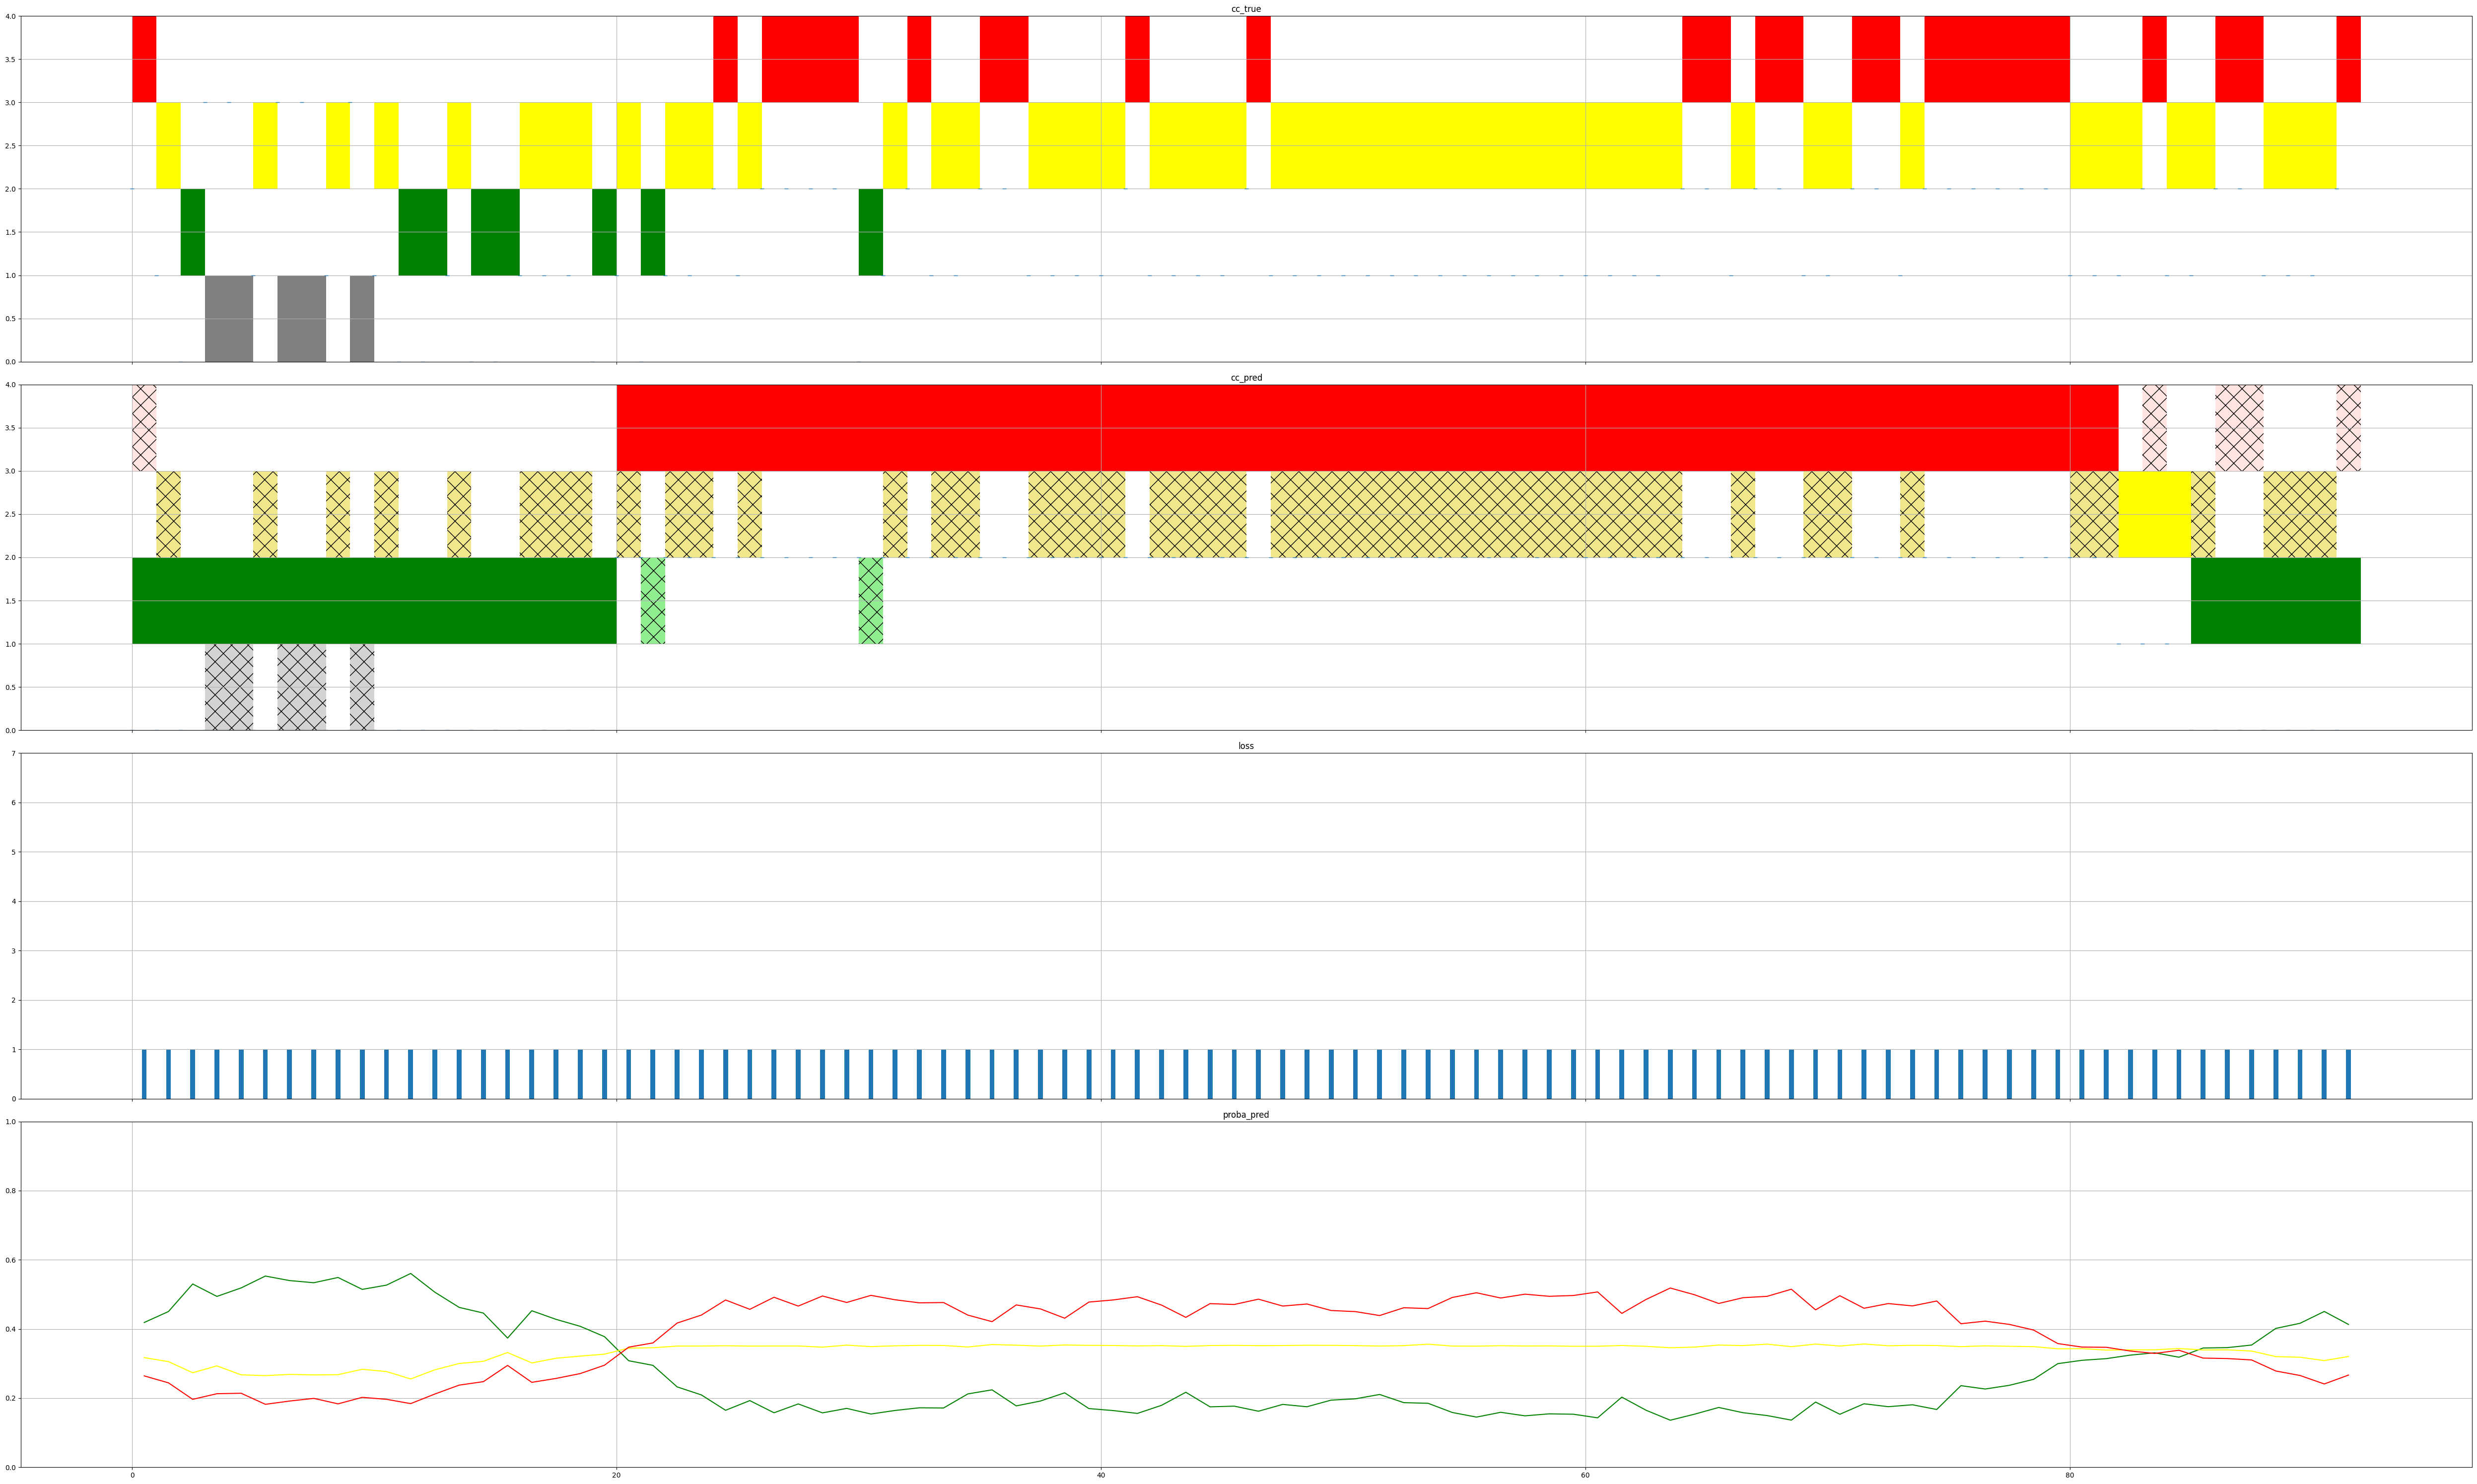

In [22]:
# Elephant and castle, northbound

u = 2180693488
v = 1868411754
plot(u, v, plot_df)

[2022-08-18 20:16:04,848][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:04,876][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:04,912][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:04,947][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:04,980][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:05,030][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:05,089][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:05,104][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in

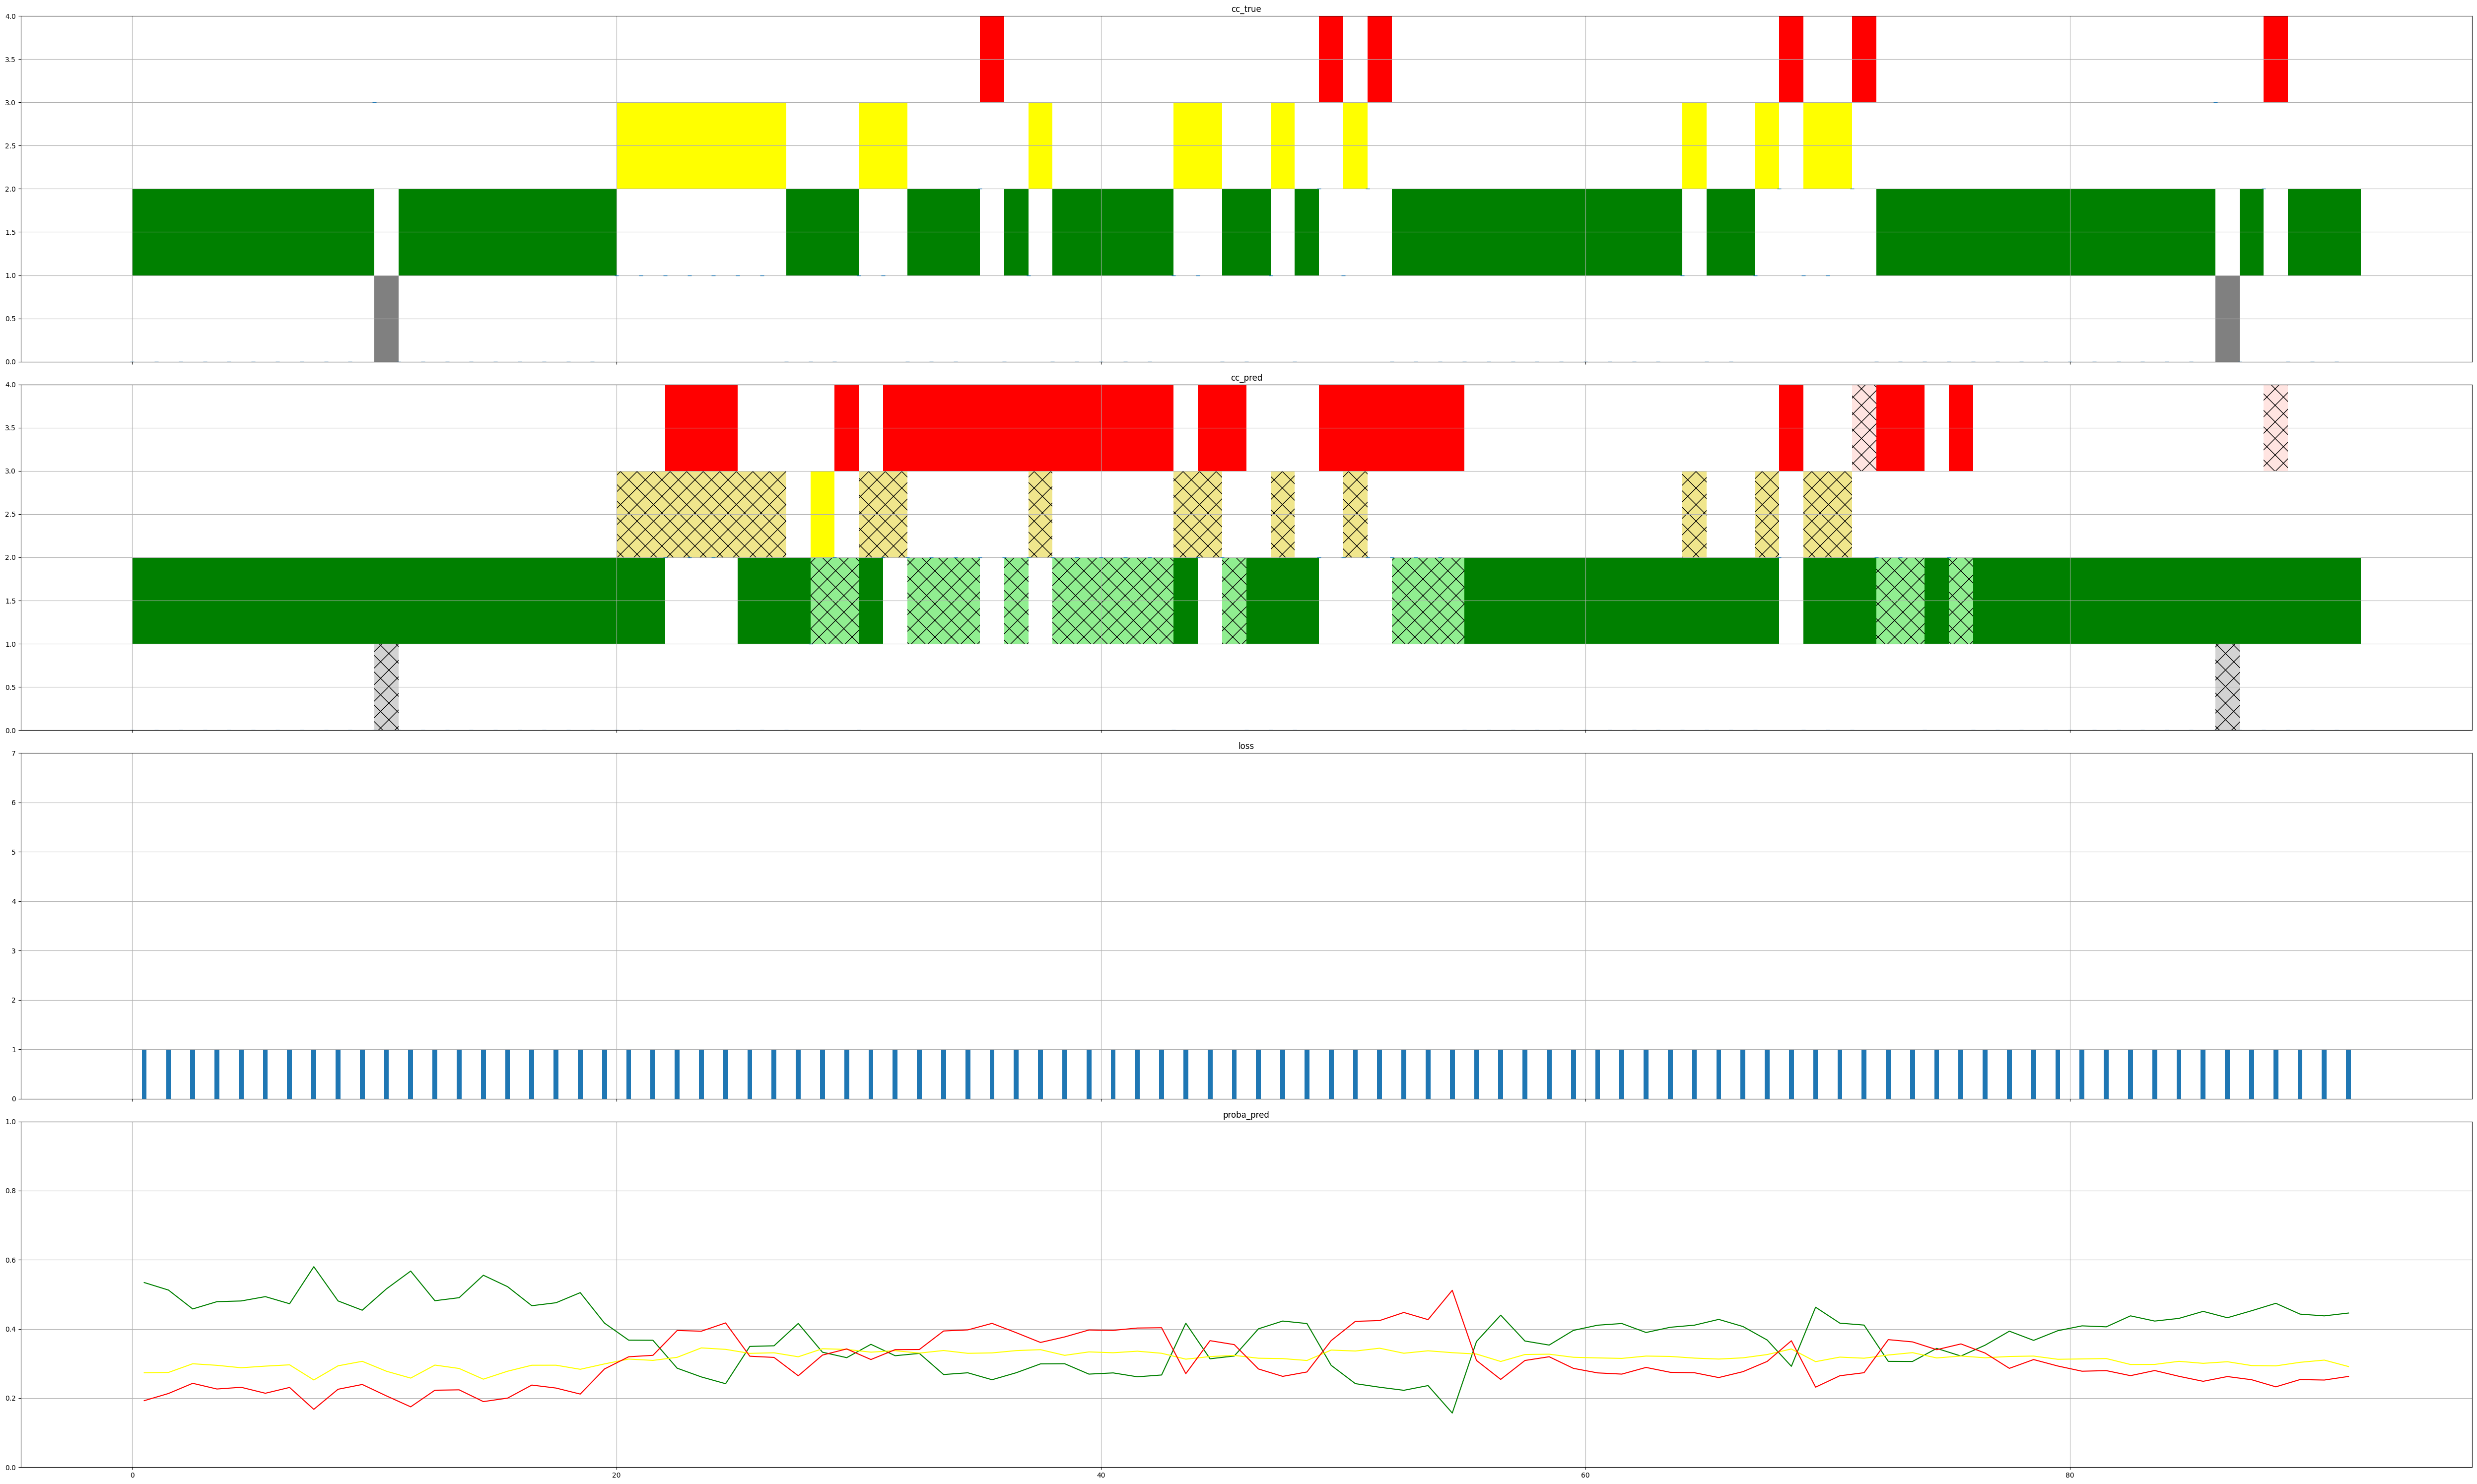

In [23]:
# M25 near Waltham, eastbound
u = 4737949241782541459
v = 5177230596161574999
plot(u, v, plot_df)

[2022-08-18 20:16:12,420][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:12,446][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:12,477][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:12,514][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:12,547][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:12,610][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:12,667][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in the figure, so title not moved
[2022-08-18 20:16:12,682][DEBUG][238524][_base.py:_update_title_position:3003] top of Axes not in

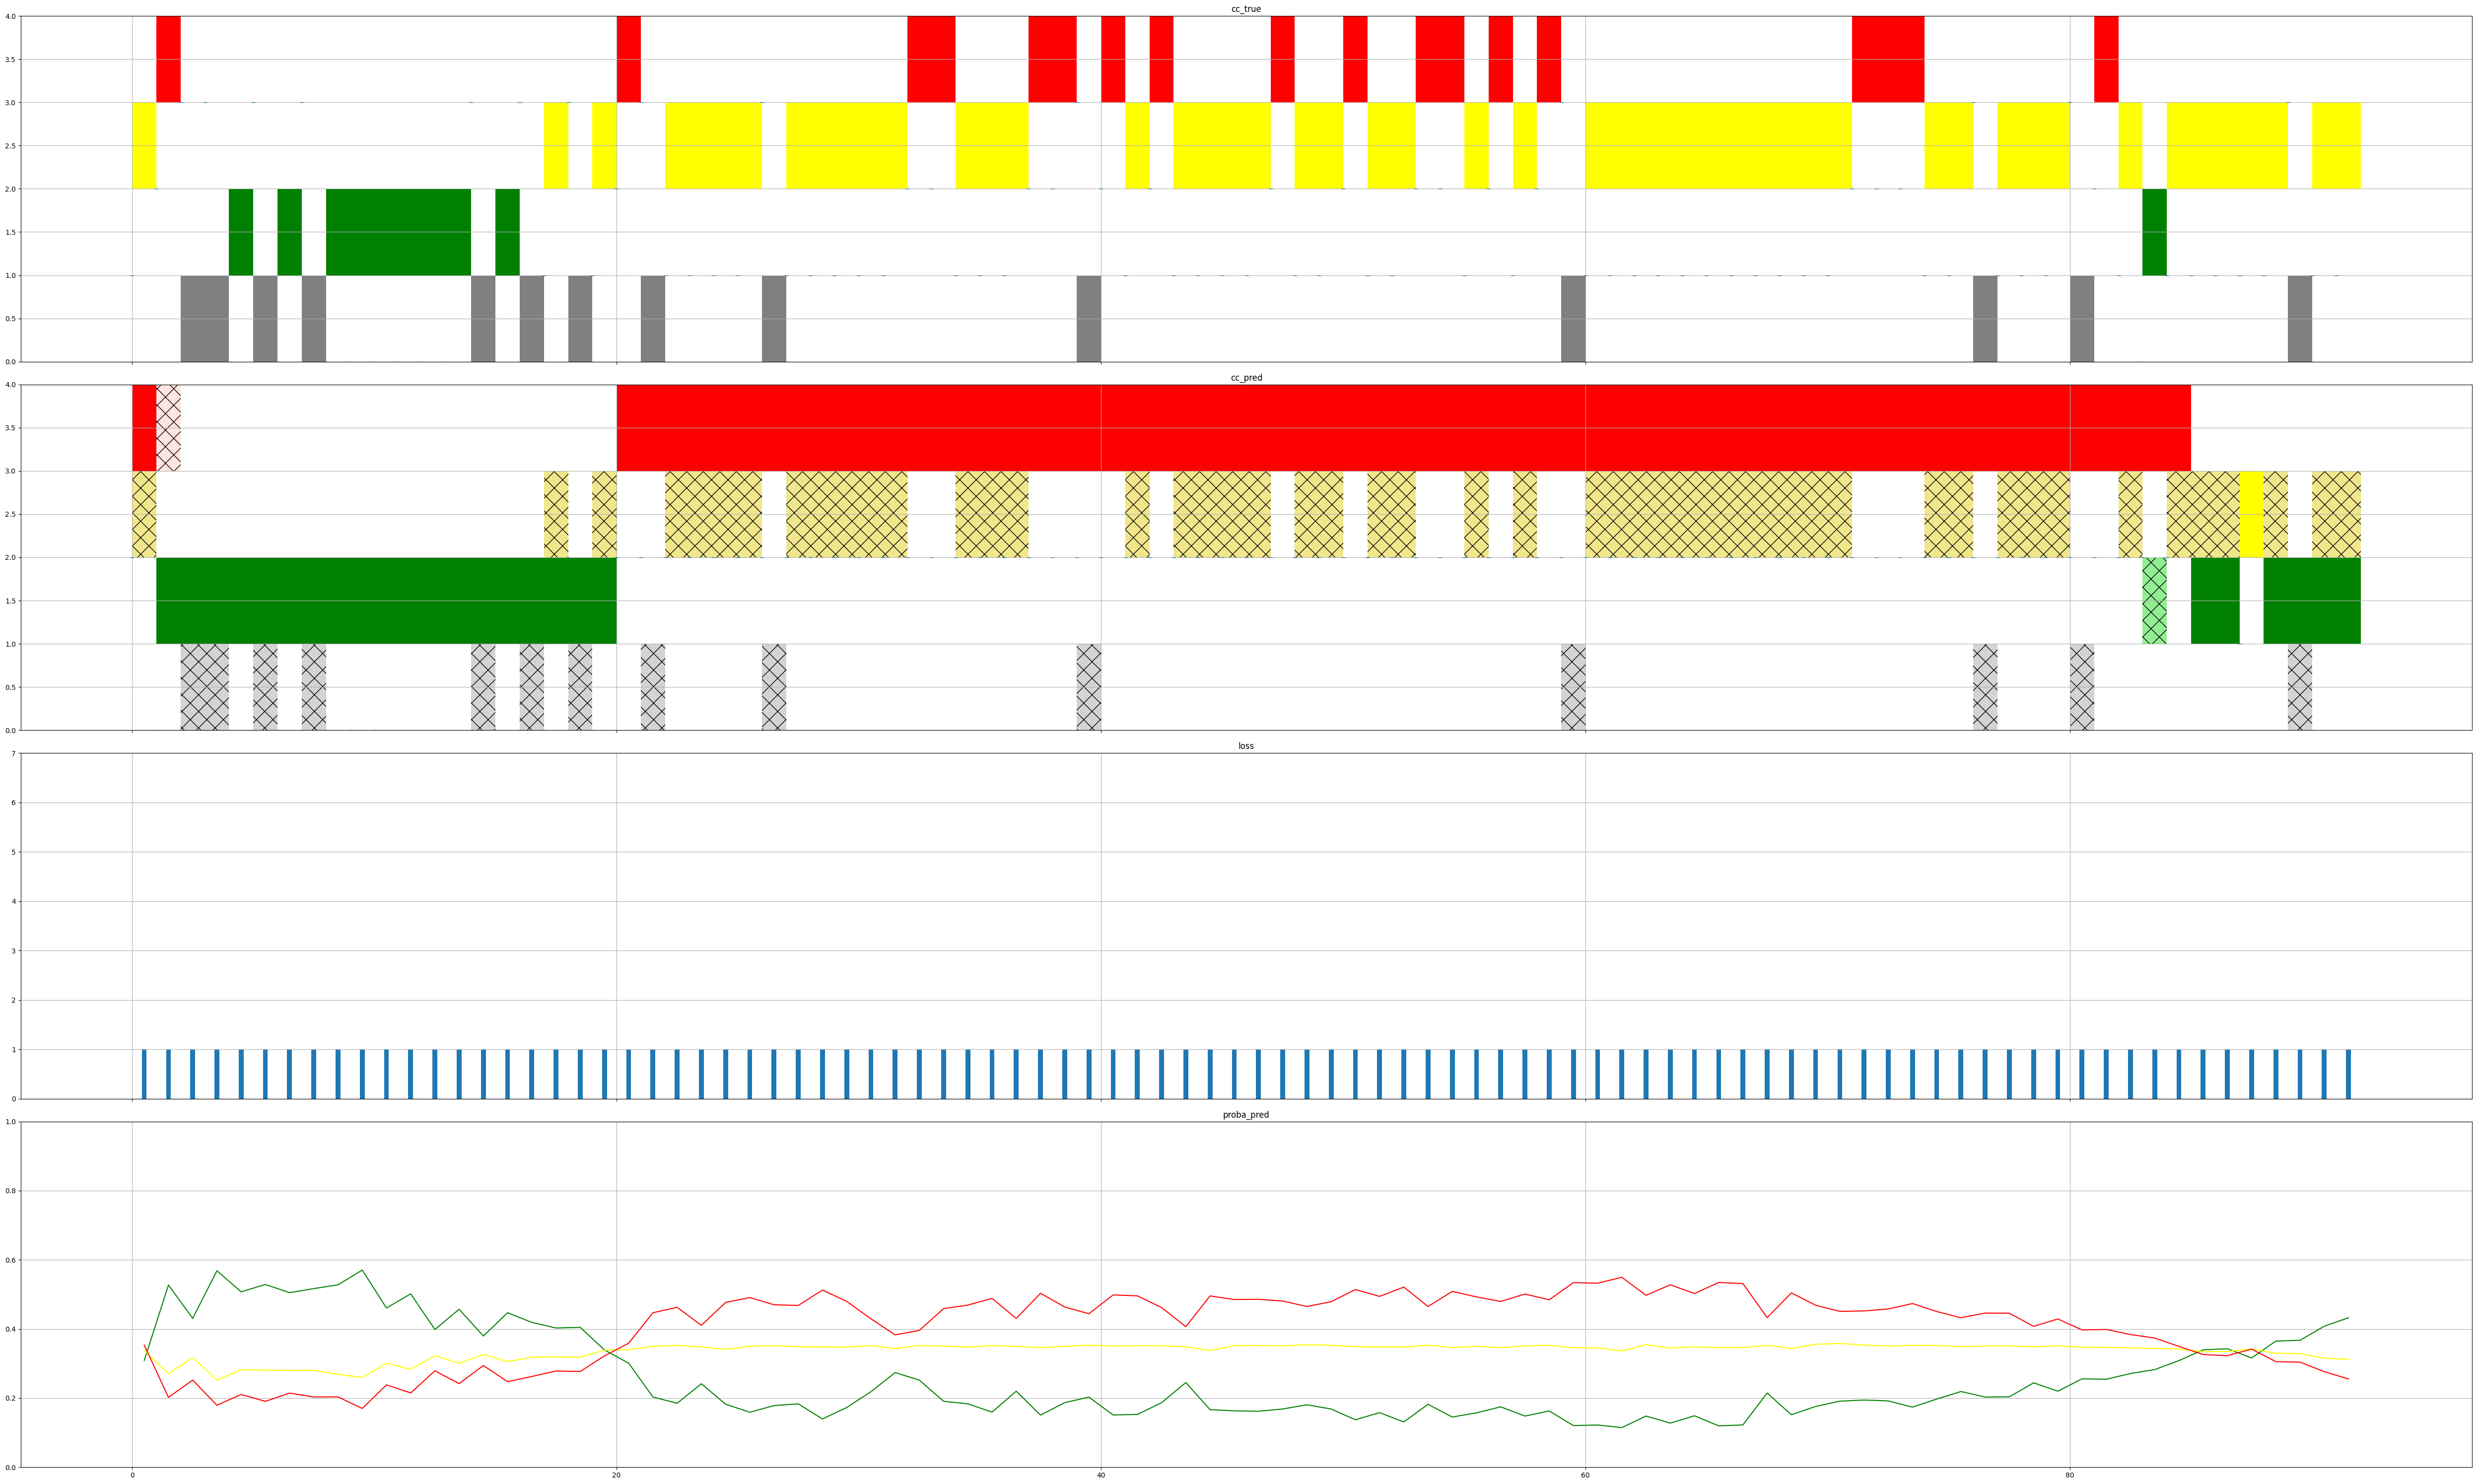

In [24]:
# at counter 08/093
u = 2180661925
v = 8953368684960847732
plot(u, v, plot_df)